In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import tqdm

from models import PixelCNN


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
BS = 128
dataset = torchvision.datasets.MNIST(root = '.',download = False, transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()]))
#Important no Normalize since we want image between 0, 1 to get the targets as int [0, ..., 255]
dataloader = DataLoader(dataset,batch_size=BS, shuffle=True)

# Start with lesser dimensionality channels, first only predict black or white. One channel output

In [3]:
nb_classes = 2

def quantisize(images, levels):
    return (torch.bucketize(images, torch.arange(levels).to(images.device) / levels, right = True)-1).long()

In [4]:
z = torch.rand(4,4)
z

tensor([[0.9856, 0.7071, 0.6806, 0.5570],
        [0.9573, 0.4177, 0.7436, 0.9231],
        [0.5505, 0.5772, 0.7301, 0.9214],
        [0.0533, 0.7345, 0.8012, 0.0828]])

In [5]:
quantisize(z,2)

tensor([[1, 1, 1, 1],
        [1, 0, 1, 1],
        [1, 1, 1, 1],
        [0, 1, 1, 0]])

In [6]:
nb_layers = 6
channel = 64

img_channel = dataloader.dataset[0][0].shape[0]
device = torch.device('cuda')

In [7]:
model = PixelCNN(in_channel = img_channel, hidden_channel = channel, nb_blocks = nb_layers)
model.to(device)

lr = 0.001
optim = torch.optim.AdamW(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
binary_criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,  factor = 0.5, patience = 100, verbose = True)

In [8]:
nb_epochs = 25
losses = []

model.train()
for _ in range(nb_epochs):
    pbar = tqdm.tqdm(dataloader)
    for x, _ in pbar:
        img = quantisize(x,2).to(device).float()
        optim.zero_grad()

        out = model(2*(img-.5))

        loss = binary_criterion(out, img)
        

        loss.backward()

        nn.utils.clip_grad_norm(model.parameters(), 1)
        optim.step()
        #scheduler.step(loss)


        losses.append(loss.item())
        pbar.set_description(f'Loss: %.3f' % loss.item())



  0%|          | 0/469 [00:00<?, ?it/s]C:\Users\yanne\AppData\Local\Temp\ipykernel_21952\2659251405.py:18: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), 1)
Loss: 0.074: 100%|██████████| 469/469 [03:11<00:00,  2.44it/s]


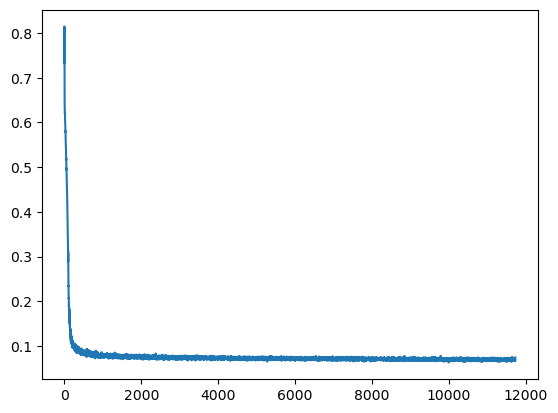

In [12]:
plot(losses)

In [68]:
#torch.save(model.cpu().state_dict(), './model_saves/pixelcnnMNIST.pth')
#model.load_state_dict(torch.load('./model_saves/pixelcnnMNIST.pth'))

<All keys matched successfully>

In [72]:
img = model.generate(16,28)
grid = torchvision.utils.make_grid(img.cpu(), nrow = 4)

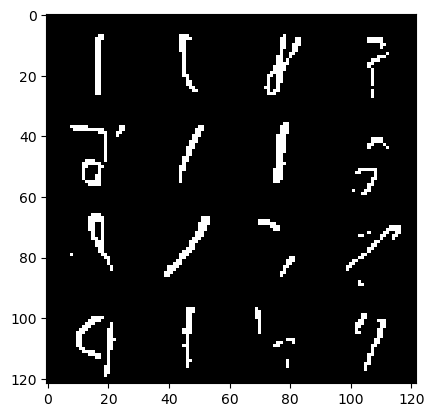

In [73]:
#grid = torchvision.utils.make_grid(img.cpu(), nrow = 10)
imshow(grid.permute(1,2,0))

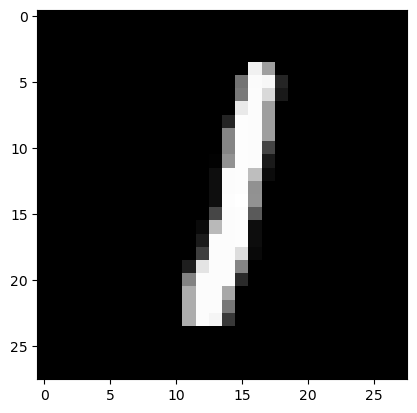

In [57]:
grid = torchvision.utils.make_grid(x[0].float().cpu(), nrow = 8)
imshow(grid.permute(1,2,0))

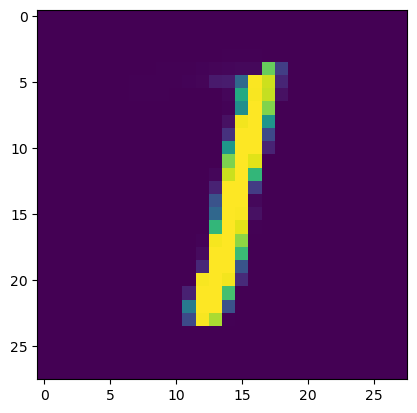

In [58]:
with torch.no_grad(): 
    imshow(model((x[0].unsqueeze(0).to(device)-.5)*2).cpu().numpy()[0,0])

In [59]:
BS = 128
test_dataset = torchvision.datasets.MNIST(root = '.',download = False, train = False,transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()]))
#Important no Normalize since we want image between 0, 1 to get the targets as int [0, ..., 255]
test_dataloader = DataLoader(test_dataset,batch_size=BS, shuffle=True)

In [60]:
batch = next(iter(test_dataloader))[0]

In [61]:
model.eval()
with torch.no_grad():
    batch = quantisize(batch,2).to(device).float()
    out = model(2*(batch-.5))

    loss = binary_criterion(out, batch)


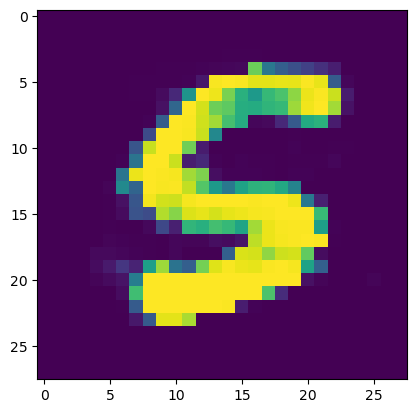

In [62]:
imshow(out[0,0].cpu().numpy())

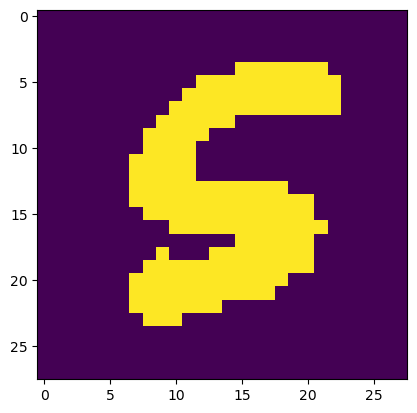

In [63]:
imshow(batch[0,0].cpu().numpy())